In this notebook, we show the result of estimation of lower bound of hazard rate.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

#from codes.UCB_discrete import M_UCB, UCB1, UCB_V, MV_LCB, Exp3, epsilon_greedy, Median_of_Means_UCB, U_UCB
from codes.Environment import Mixture_AbsGau, setup_env, Exp, est_L_test
from codes.SimulatedGames import simulate
from codes.plots import plot_hist, plot_eva

%matplotlib inline

In [3]:
# setting

num_exper = 50
num_rounds = 10000
num_arms = 3
est_flag = True # estimate the lower bound of hazard rate L
tau = 0.5

# environment

environments = [
    {Mixture_AbsGau: [[0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                     ],
     Exp: [[1/4]]
    } # mu1, sigma1, mu2, sigma2, p
    
]

rewards_env, quantiles, Ls, means, samples = setup_env(environments, tau)

{<class 'codes.Environment.Mixture_AbsGau'>: [[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1]], <class 'codes.Environment.Exp'>: [[0.25]]}


In [4]:
arm_name_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
}

for key in quantiles.keys():
    print(key)
    quantiles[key] = list(np.around(np.array(quantiles[key]),2))
    means[key] = list(np.around(np.array(means[key]),2))
    t = PrettyTable(['Eva', 'A', 'B', 'C', 'Best Arm'])
    t.add_row([str(tau) + '-Quantile'] + quantiles[key]+ [arm_name_dict[np.argmax(quantiles[key])]])
    t.add_row(['Mean']+ means[key]+ [arm_name_dict[np.argmax(means[key])]])
    t.add_row(['L']+ Ls[key]+ [arm_name_dict[np.argmax(Ls[key])]])
    print(t)
    print()

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1]]Exp_[[0.25]]
+--------------+--------------------+---------------------+------+----------+
|     Eva      |         A          |          B          |  C   | Best Arm |
+--------------+--------------------+---------------------+------+----------+
| 0.5-Quantile |        1.01        |         3.51        | 2.76 |    B     |
|     Mean     |        1.2         |         3.57        | 3.98 |    C     |
|      L       | 0.5319230405352436 | 0.08627731882651153 | 0.25 |    A     |
+--------------+--------------------+---------------------+------+----------+



## Lower bound of hazard rate estimation

Our policy and bound of expected sub-optimal draws depend on the lower bound of hazard rate. One interesting question is how well we can estimate the lower bound of hazard rate ($\hat{L}_i$), and the sensitivity of our policy to the $\hat{L}_i$. 

In [5]:
true_L_list = list(Ls.values())[0]

In [63]:
sample_size = 200
est_method = 'naive'
bandwidth = 1.145
num_exper = 10

est_L_dict = est_L_test(environments, num_exper, sample_size, est_method, bandwidth)

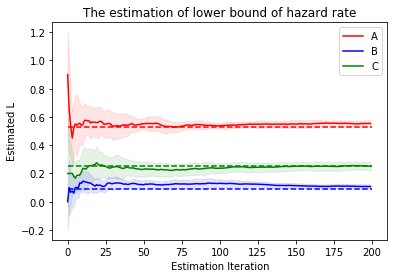

In [64]:
colors = ['red', 'blue', 'green']
        
for arm_idx, est_L_lists in est_L_dict.items():
    mean = np.mean(np.asarray(est_L_lists), axis = 0)
    std = np.std(np.asarray(est_L_lists), axis = 0)
    
    plt.plot([0, len(mean)], [true_L_list[arm_idx], true_L_list[arm_idx]], '--', color = colors[arm_idx])
    plt.plot(range(len(mean)), mean, color = colors[arm_idx], label = arm_name_dict[arm_idx])
    plt.fill_between(range(len(mean)), mean + std, mean - std, color = colors[arm_idx], alpha = 0.1)
    plt.ylabel('Estimated L')
    plt.xlabel('Estimation Iteration')
    plt.title('The estimation of lower bound of hazard rate')
    plt.legend()
    
plt.savefig('est_L.pdf')
plt.show()

The above plot shows the estimated value of $\hat{L}_i$ for 10,000 rounds experiment under policy M-UCB. Note that the choice of sample arm depends on the policy and the number of samples of each arm is not same. We can see for all arms, the estimated $\hat{L}_i$ converges to the true value (dash line with the same colour) exponentially fast. The estimation remains stable after around 1,000 rounds.

We further show the root mean squared error (RMSE) of lower bound of hazard rate estimation for the first 1,000 iterations. We observe that the error drops exponentially fast for the first 200 iterations and then drops slowly. 

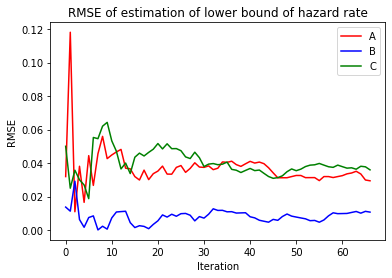

In [38]:


for arm_idx, est_L_lists in est_L_dict.items():
    mean = np.mean(np.asarray(est_L_lists), axis = 0)
    std = np.std(np.asarray(est_L_lists), axis = 0)
    
    plt.plot(range(len(mean[::3])), (np.sqrt((mean - true_L_list[arm_idx])** 2)[::3]), color = colors[arm_idx], label = arm_name_dict[arm_idx])

    plt.ylabel('RMSE')
    #plt.ylim([0.2, 0.5])
    plt.xlabel('Iteration')
    plt.title('RMSE of estimation of lower bound of hazard rate')
    plt.legend()
    
plt.savefig('RMSE_est_L.pdf')

## Save results

In [ ]:
with open('results_est_L.pickle', 'wb') as handle:
    pickle.dump(results_est_L, handle, protocol=pickle.HIGHEST_PROTOCOL)